In [1]:
%pip install h5py seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os
import math
import glob
from datetime import datetime
from datetime import timedelta
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import KDTree

In [ ]:
cemaden_path = r'.\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\BRASIL_CEMADEN_TOTAL_DAILY_V2.h5'

In [241]:
def calculate_quality_label(row):
    if row['q1_gaps'] < 90 or row['q2_week'] < 60 or row['q3_outliers'] < 60:
     return '5 - Very Low Quality'
    elif row['quality_index'] >= 90 and row['p_availability'] >= 99:
        return '1 - Excellent Quality'
    elif row['quality_index'] >= 85 and row['p_availability'] >= 95:
        return '2 - Good Quality'
    elif row['quality_index'] >= 80 and row['p_availability'] >= 90:
        return '3 - Acceptable Quality'
    elif row['quality_index'] >= 50:
        return '4 - Low Quality'
    else:
        return '5 - Very Low Quality'
    
    # row['q1_gaps'] < 90 or row['q2_week'] < 60 or row['q3_outliers'] < 60:
    #  return '5 - Very Low Quality'
    # elif

In [5]:
def absolute_quality_label(row):
    if row['quality_label'] in ['Excellent Quality', 'Good Quality', 'Acceptable Quality']:
        return 'HQ'
    elif row['quality_label'] in ['Low Quality', 'Very Low Quality']:
        return 'LQ'
    else:
        return 'Unknown'

# Reading data

In [25]:
df_cemaden_data = pd.read_hdf(cemaden_path, key='table_data')
# df_cemaden_data.pop('index')
df_cemaden_data

,gauge_code,datetime,rain_mm
0,230370901A,2014-01-01,0.0
1,230370902A,2014-01-01,0.0
2,230370903A,2014-01-01,0.0
3,230370904A,2014-01-01,0.0
4,230370905A,2014-01-01,0.0
...,...,...,...
11236369,530010801A,2024-12-31,0.2
11236370,530010802A,2024-12-31,0.0
11236371,530010803A,2024-12-31,2.0
11236372,530010804A,2024-12-31,0.2


In [27]:
df_cemaden_data['year'] = df_cemaden_data['datetime'].dt.year
df_cemaden_data = df_cemaden_data[(df_cemaden_data['datetime']<= '2020-12-31')
                                    & (df_cemaden_data['rain_mm']>= 0.0)].reset_index(drop=True)
# df_cemaden_data.pop('index')
df_cemaden_data

,gauge_code,datetime,rain_mm,year
0,230370901A,2014-01-01,0.00,2014
1,230370902A,2014-01-01,0.00,2014
2,230370903A,2014-01-01,0.00,2014
3,230370904A,2014-01-01,0.00,2014
4,230370905A,2014-01-01,0.00,2014
...,...,...,...,...
6809093,530010804A,2020-12-31,25.00,2020
6809094,530010805A,2020-12-31,0.00,2020
6809095,CEMADEN_10,2020-12-31,0.79,2020
6809096,CEMADEN_11,2020-12-31,1.38,2020


In [ ]:
df_cemaden_info = pd.read_hdf(cemaden_path, key = 'table_info')
df_cemaden_info['lat'] = df_cemaden_info['lat'].astype(float)
df_cemaden_info['long'] = df_cemaden_info['long'].astype(float)
df_cemaden_info.sort_values(['state', 'city'], inplace=True)
df_cemaden_info.reset_index(drop=True, inplace=True)
df_cemaden_info

,gauge_code,state,city,name_station,long,lat
0,120010401A,AC,BRASILÉIA,Centro,-68.740939,-11.012469
1,120032801A,AC,JORDÃO,Centro,-71.950808,-9.190133
2,120040101A,AC,RIO BRANCO,AC Oca,-67.806662,-9.972969
3,120040102H,AC,RIO BRANCO,Igarape Sao Francisco,-67.819980,-9.945025
4,120040101H,AC,RIO BRANCO,Igarape Judia,-67.880229,-9.937753
...,...,...,...,...,...,...
4296,171830301A,TO,PRAIA NORTE,Prefeitura Municipal,-47.811400,-5.395600
4297,171886501A,TO,SANTA FÉ DO ARAGUAIA,Prefeitura Municipal,-48.690830,-7.148690
4298,172020001A,TO,SÃO MIGUEL DO TOCANTINS,Centro Cultural,-47.577580,-5.552650
4299,172030901A,TO,SÃO SEBASTIÃO DO TOCANTINS,Viveiro Municipal,-48.202500,-5.261600


In [70]:
df_cemaden_info.to_hdf(cemaden_path, key='table_info', mode='r+', format='table', index=False, complevel = 9, append=False)

In [71]:
len(df_cemaden_data['gauge_code'].unique())

4178

In [72]:
years = df_cemaden_data['year'].sort_values(ascending=True).drop_duplicates().values.tolist()
years

[2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [73]:
df_complete_info = pd.merge(df_cemaden_data, df_cemaden_info, on='gauge_code', how = 'inner').sort_values('lat', ascending = True).reset_index(drop=True)   
df_complete_info

,gauge_code,datetime,rain_mm,year,state,city,name_station,long,lat
0,431100701A,2018-05-15,0.00,2018,RS,JAGUARÃO,Pindorama,-53.368358,-32.558556
1,431100701A,2020-08-24,0.00,2020,RS,JAGUARÃO,Pindorama,-53.368358,-32.558556
2,431100701A,2017-08-25,0.00,2017,RS,JAGUARÃO,Pindorama,-53.368358,-32.558556
3,431100701A,2018-04-25,0.20,2018,RS,JAGUARÃO,Pindorama,-53.368358,-32.558556
4,431100701A,2019-08-03,0.00,2019,RS,JAGUARÃO,Pindorama,-53.368358,-32.558556
...,...,...,...,...,...,...,...,...,...
6809093,140070401A,2018-12-20,0.00,2018,RR,UIRAMUTÃ,Centro,-60.162963,4.594482
6809094,140070401A,2018-12-21,0.00,2018,RR,UIRAMUTÃ,Centro,-60.162963,4.594482
6809095,140070401A,2018-12-22,0.00,2018,RR,UIRAMUTÃ,Centro,-60.162963,4.594482
6809096,140070401A,2018-12-18,4.34,2018,RR,UIRAMUTÃ,Centro,-60.162963,4.594482


# Preclassif

In [75]:
# Add a year column to the dataframe
df_cemaden_data['year'] = df_cemaden_data['datetime'].dt.year

# Group by gauge_code and year
grouped = df_cemaden_data.groupby(['gauge_code', 'year'])

# Calculate annual_rainfall_mm, active_days, and consecutive_dry_days
def calculate_metrics(group):
    annual_rainfall_mm = group['rain_mm'].sum()
    active_days = (group['rain_mm'] >= 0.0).sum()
    
    # Calculate consecutive dry days
    dry_days = (group['rain_mm'] == 0.0).astype(int)
    # Calculate the maximum number of consecutive dry days
    consecutive_dry_days = (dry_days.groupby((dry_days != dry_days.shift()).cumsum()).cumsum() * dry_days).max()
    
    return pd.Series({
        'annual_rainfall_mm': annual_rainfall_mm,
        'active_days': active_days,
        'consecutive_dry_days': consecutive_dry_days
    })

In [76]:
df_preclassif = grouped.apply(calculate_metrics).reset_index()
df_preclassif

C:\Users\linde\AppData\Local\Temp\ipykernel_13128\356056228.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_preclassif = grouped.apply(calculate_metrics).reset_index()


,gauge_code,year,annual_rainfall_mm,active_days,consecutive_dry_days
0,110018901A,2018,969.740000,136.0,21.0
1,110018901A,2019,1786.230000,365.0,58.0
2,110018901A,2020,347.270000,366.0,328.0
3,110020501A,2014,108.270409,16.0,2.0
4,110020501A,2017,138.460000,92.0,55.0
...,...,...,...,...,...
22768,CEMADEN_12,2019,598.120000,90.0,5.0
22769,CEMADEN_12,2020,398.050000,31.0,1.0
22770,CEMADEN_13,2019,51.800000,30.0,12.0
22771,CEMADEN_14,2018,436.400000,92.0,3.0


In [77]:
df_preclassif = grouped.apply(calculate_metrics).reset_index()
df_preclassif
df_preclassif['preclassif'] = df_preclassif.apply(
    lambda row: 'LQ' if (row['annual_rainfall_mm'] < 200 or row['annual_rainfall_mm'] > 6000
                        #  or row['active_days'] < 305
                         or row['consecutive_dry_days'] > 200) else "", axis=1)
df_preclassif

C:\Users\linde\AppData\Local\Temp\ipykernel_13128\3228001494.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_preclassif = grouped.apply(calculate_metrics).reset_index()


,gauge_code,year,annual_rainfall_mm,active_days,consecutive_dry_days,preclassif
0,110018901A,2018,969.740000,136.0,21.0,
1,110018901A,2019,1786.230000,365.0,58.0,
2,110018901A,2020,347.270000,366.0,328.0,LQ
3,110020501A,2014,108.270409,16.0,2.0,LQ
4,110020501A,2017,138.460000,92.0,55.0,LQ
...,...,...,...,...,...,...
22768,CEMADEN_12,2019,598.120000,90.0,5.0,
22769,CEMADEN_12,2020,398.050000,31.0,1.0,
22770,CEMADEN_13,2019,51.800000,30.0,12.0,LQ
22771,CEMADEN_14,2018,436.400000,92.0,3.0,


In [78]:
preclassif_counts = df_preclassif['preclassif'].value_counts()
print(preclassif_counts)

preclassif
      19172
LQ     3601
Name: count, dtype: int64


In [79]:
preclassif_counts['LQ'] / preclassif_counts.sum()

0.15812585078821412

In [80]:
df_preclassif.to_hdf(cemaden_path, key='table_preclassif', mode='r+', complevel=9, complib='zlib')
df_preclassif

,gauge_code,year,annual_rainfall_mm,active_days,consecutive_dry_days,preclassif
0,110018901A,2018,969.740000,136.0,21.0,
1,110018901A,2019,1786.230000,365.0,58.0,
2,110018901A,2020,347.270000,366.0,328.0,LQ
3,110020501A,2014,108.270409,16.0,2.0,LQ
4,110020501A,2017,138.460000,92.0,55.0,LQ
...,...,...,...,...,...,...
22768,CEMADEN_12,2019,598.120000,90.0,5.0,
22769,CEMADEN_12,2020,398.050000,31.0,1.0,
22770,CEMADEN_13,2019,51.800000,30.0,12.0,LQ
22771,CEMADEN_14,2018,436.400000,92.0,3.0,


# Outlier treatment

In [81]:
df_outlier = pd.merge(df_complete_info[['gauge_code', 'rain_mm', 'datetime', 'year']], df_preclassif, on = ['gauge_code', 'year'], how = 'left')
df_outlier = df_outlier[df_outlier['preclassif'] != 'LQ']
df_outlier = df_outlier[['gauge_code',	'datetime',	'rain_mm']]
df_outlier

,gauge_code,datetime,rain_mm
0,431100701A,2018-05-15,0.00
1,431100701A,2020-08-24,0.00
2,431100701A,2017-08-25,0.00
3,431100701A,2018-04-25,0.20
4,431100701A,2019-08-03,0.00
...,...,...,...
6809093,140070401A,2018-12-20,0.00
6809094,140070401A,2018-12-21,0.00
6809095,140070401A,2018-12-22,0.00
6809096,140070401A,2018-12-18,4.34


In [102]:
def mark_outlier_rain(df, threshold_rain_mm=200):
    # Garantir que a coluna 'datetime' está no formato datetime
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Ordenar por estação e data
    df_sorted = df.sort_values(['gauge_code', 'datetime']).copy()

    # Calcular chuva do dia anterior e do dia seguinte
    df_sorted['yesterday_rain_mm'] = df_sorted.groupby('gauge_code')['rain_mm'].shift(1)
    df_sorted['tomorrow_rain_mm'] = df_sorted.groupby('gauge_code')['rain_mm'].shift(-1)

    # Calcular soma da chuva nos dias adjacentes
    df_sorted['adjacent_days_mm'] = df_sorted['yesterday_rain_mm'] + df_sorted['tomorrow_rain_mm']

    # Regra para identificar outlier
    condition = (
        (df_sorted['rain_mm'] > threshold_rain_mm) &
        (df_sorted['adjacent_days_mm'] < 0.025 * df_sorted['rain_mm'])
    )

    df_sorted['outlier_status_1'] = np.where(condition, 1, 0)

    return df_sorted

# Aplicar na base df_outlier_filter_1
df_outlier_filter_1 = mark_outlier_rain(df_outlier)
df_outlier_filter_1

,gauge_code,datetime,rain_mm,yesterday_rain_mm,tomorrow_rain_mm,adjacent_days_mm,outlier_status_1
5037596,110018901A,2018-08-18,15.66,NaN,12.22,NaN,0
5037639,110018901A,2018-08-19,12.22,15.66,0.00,15.66,0
5037668,110018901A,2018-08-20,0.00,12.22,0.00,12.22,0
5037260,110018901A,2018-08-21,0.00,0.00,0.00,0.00,0
5037742,110018901A,2018-08-22,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...
2927535,CEMADEN_14,2019-04-26,0.00,0.00,0.00,0.00,0
2927554,CEMADEN_14,2019-04-27,0.00,0.00,0.00,0.00,0
2927532,CEMADEN_14,2019-04-28,0.00,0.00,6.20,6.20,0
2927538,CEMADEN_14,2019-04-29,6.20,0.00,0.00,0.00,0


In [103]:
neighboring_data_path = r'.\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET'
neighboring_data_path


'.\\1 - Organized data gauge\\BRAZIL\\QC_VALIDATION\\DATASET'

In [104]:
df_outlier_filter_1_export = df_outlier_filter_1[df_outlier_filter_1['outlier_status_1'] == 1]
df_outlier_filter_1_export.to_hdf(
        os.path.join(neighboring_data_path, "adjacent_day_analysis_filter_1.h5"),
        key='table_data',
        mode='w',
        format='table',
        complevel=9,
        encoding='utf-8',
        append=False,
        min_itemsize={'gauge_code': 20}  # Adjust based on your max gauge code length
    )
df_outlier_filter_1_export

,gauge_code,datetime,rain_mm,yesterday_rain_mm,tomorrow_rain_mm,adjacent_days_mm,outlier_status_1
5276677,120032801A,2020-11-23,218.80,0.0,0.00,0.00,1
6768731,150480202A,2019-11-17,240.20,0.0,1.00,1.00,1
6767867,150480203A,2019-11-17,239.60,0.0,2.60,2.60,1
6591652,210210102A,2020-05-18,861.64,0.0,5.73,5.73,1
6748654,211130007A,2016-01-23,213.60,0.0,3.80,3.80,1
...,...,...,...,...,...,...,...
1028642,421740205A,2015-12-05,224.15,0.0,0.20,0.20,1
74191,431490219A,2018-01-10,296.42,0.0,0.62,0.62,1
42071,431640202A,2018-03-24,253.80,0.0,0.80,0.80,1
102071,431840801A,2019-09-07,1382.06,0.8,3.76,4.56,1


In [105]:
df_outlier_filter_1 = df_outlier_filter_1[['gauge_code','datetime',	'rain_mm', 'outlier_status_1']]
df_outlier_filter_1 = df_outlier_filter_1[df_outlier_filter_1['outlier_status_1']==0]
df_outlier_filter_1 = pd.merge(df_outlier_filter_1, df_cemaden_info[['gauge_code', 'lat', 'long']], on ='gauge_code', how='left')

df_outlier_filter_1.sort_values(['datetime', 'lat', 'long'], ascending=True, inplace=True)
df_outlier_filter_1.reset_index(drop=True, inplace=True)
df_outlier_filter_1

,gauge_code,datetime,rain_mm,outlier_status_1,lat,long
0,230420201A,2014-01-01,0.000000,0,-7.269000,-39.458000
1,230420202A,2014-01-01,7.300969,0,-7.268000,-39.433000
2,230730401A,2014-01-01,0.000000,0,-7.225000,-39.319000
3,231140501A,2014-01-01,0.000000,0,-5.198000,-39.302000
4,230870803A,2014-01-01,0.000000,0,-5.113000,-38.374000
...,...,...,...,...,...,...
6170170,160030305A,2020-12-31,0.000000,0,-0.092696,-51.065317
6170171,160060002A,2020-12-31,2.200000,0,-0.049122,-51.144532
6170172,160060003A,2020-12-31,1.200000,0,-0.041263,-51.179238
6170173,160030304A,2020-12-31,2.800000,0,-0.002212,-51.100888


In [106]:
def idw_interpolation(latitude, longitude, df_temp_without_gauge, kdtree, p=2):
    row = [latitude, longitude]
    distances, indices = kdtree.query(row, k=5)
    weights = 1 / (distances + 1e-6) ** p
    values = df_temp_without_gauge.iloc[indices]['rain_mm'].values
    return (np.sum(weights * values) / np.sum(weights))

# Initialize empty DataFrame for results
outlier_analysis_results = pd.DataFrame()

# Configurations
output_filename = os.path.join(neighboring_data_path, "neighboring_analysis.h5")
rainfall_threshold = 200.0  # mm

start_date = '2014-01-01'
end_date = '2020-12-31'

df_date = df_outlier_filter_1.loc[(df_outlier_filter_1['datetime'] >= start_date) & (df_outlier_filter_1['datetime'] <= end_date)].sort_values('datetime', ignore_index=True, ascending=True)

# Get sorted unique dates
analysis_dates = df_date['datetime'].unique().tolist()
analysis_dates.sort()

# Process each date
for current_date in analysis_dates[:]:
    # Filter data for current date
    daily_data = df_outlier_filter_1[df_outlier_filter_1['datetime'] == current_date]
    gauge_codes = daily_data['gauge_code'].unique()
    
    date_results = []
    
    for gauge in gauge_codes:
        gauge_data = daily_data[daily_data['gauge_code'] == gauge].iloc[0]
        lat, lon = gauge_data['lat'], gauge_data['long']
        observed_rain = gauge_data['rain_mm']
        
        # Initialize result row
        result_row = {
            'gauge_code': gauge,
            'datetime': current_date,
            'lat': lat,
            'long': lon,
            'observed_rain_mm': observed_rain,
            'interpolated_rain_mm': np.nan
        }
        
        # Only interpolate for high rainfall values
        if observed_rain > rainfall_threshold:
            neighbor_data = daily_data[daily_data['gauge_code'] != gauge]
            
            if len(neighbor_data) > 0:
                kd_tree = KDTree(neighbor_data[['lat', 'long']].values)
                result_row['interpolated_rain_mm'] = idw_interpolation(lat, lon, neighbor_data, kd_tree)
        
        date_results.append(pd.DataFrame([result_row]))
    
    # Combine results for current date
    daily_results = pd.concat(date_results, ignore_index=True)
    
    # Save to HDF5 with proper configuration
    storage_mode = 'w' if current_date == analysis_dates[0] else 'a'
    append_mode = False if current_date == analysis_dates[0] else True

    # storage_mode = 'r+'
    # append_mode = True
    
    daily_results.to_hdf(
        output_filename,
        key='table_data',
        mode=storage_mode,
        format='table',
        complevel=9,
        encoding='utf-8',
        append=append_mode,
        min_itemsize={'gauge_code': 20}  # Adjust based on your max gauge code length
    )
    
    print(f"Saved results for {current_date} to {output_filename}")

Saved results for 2014-01-01 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-01-02 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-01-03 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-01-04 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-01-05 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-01-06 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-01-07 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-01-08 00:00:00 to .\1 - Organized data gauge\BRAZIL\QC_VALIDATION\DATASET\neighboring_analysis.h5
Saved results for 2014-01-09 00:

In [107]:
output_filename = os.path.join(neighboring_data_path, "neighboring_analysis.h5")

df_outlier_2 = pd.read_hdf(output_filename, key='table_data')
df_outlier_2

,gauge_code,datetime,lat,long,observed_rain_mm,interpolated_rain_mm
0,230420201A,2014-01-01,-7.269000,-39.458000,0.000000,NaN
1,230420202A,2014-01-01,-7.268000,-39.433000,7.300969,NaN
2,230730401A,2014-01-01,-7.225000,-39.319000,0.000000,NaN
3,231140501A,2014-01-01,-5.198000,-39.302000,0.000000,NaN
4,230870803A,2014-01-01,-5.113000,-38.374000,0.000000,NaN
...,...,...,...,...,...,...
2699,160030305A,2020-12-31,-0.092696,-51.065317,0.000000,NaN
2700,160060002A,2020-12-31,-0.049122,-51.144532,2.200000,NaN
2701,160060003A,2020-12-31,-0.041263,-51.179238,1.200000,NaN
2702,160030304A,2020-12-31,-0.002212,-51.100888,2.800000,NaN


In [108]:
df_outlier_filter_2_export = df_outlier_2[df_outlier_2['interpolated_rain_mm'] >= 0.0].reset_index(drop = True)
df_outlier_filter_2_export = df_outlier_filter_2_export[df_outlier_filter_2_export['interpolated_rain_mm'] >= 0.35 * df_outlier_filter_2_export['observed_rain_mm']]
df_outlier_filter_2_export['outlier_status_2'] = 1
df_outlier_filter_2_export

,gauge_code,datetime,lat,long,observed_rain_mm,interpolated_rain_mm,outlier_status_2
4,352990601A,2014-02-15,-24.283000,-47.456000,274.084072,129.955405,1
5,355540607A,2014-02-15,-23.517000,-45.196000,211.519555,146.649750,1
6,355540613A,2014-02-15,-23.419000,-45.066000,203.908136,177.684821,1
7,330010013A,2014-03-22,-22.902000,-44.332000,219.237016,145.883307,1
12,355070402A,2014-04-14,-23.758000,-45.764000,226.889704,133.107588,1
...,...,...,...,...,...,...,...
239,354850009A,2020-03-03,-23.891000,-46.189000,204.430000,165.382992,1
240,150140207A,2020-03-09,-1.164264,-48.468548,202.800000,84.500064,1
254,330250204A,2020-12-22,-22.602000,-43.190000,228.870000,220.832621,1
255,330250203A,2020-12-22,-22.594000,-43.183000,251.560000,184.869007,1


In [109]:
df_outlier_filter_2_export.to_hdf(
        os.path.join(neighboring_data_path, "neighboring_analysis_filter_2.h5"),
        key='table_data',
        mode='w',
        format='table',
        complevel=9,
        encoding='utf-8',
        append=False,
        min_itemsize={'gauge_code': 20}  # Adjust based on your max gauge code length
    )
df_outlier_filter_2_export

,gauge_code,datetime,lat,long,observed_rain_mm,interpolated_rain_mm,outlier_status_2
4,352990601A,2014-02-15,-24.283000,-47.456000,274.084072,129.955405,1
5,355540607A,2014-02-15,-23.517000,-45.196000,211.519555,146.649750,1
6,355540613A,2014-02-15,-23.419000,-45.066000,203.908136,177.684821,1
7,330010013A,2014-03-22,-22.902000,-44.332000,219.237016,145.883307,1
12,355070402A,2014-04-14,-23.758000,-45.764000,226.889704,133.107588,1
...,...,...,...,...,...,...,...
239,354850009A,2020-03-03,-23.891000,-46.189000,204.430000,165.382992,1
240,150140207A,2020-03-09,-1.164264,-48.468548,202.800000,84.500064,1
254,330250204A,2020-12-22,-22.602000,-43.190000,228.870000,220.832621,1
255,330250203A,2020-12-22,-22.594000,-43.183000,251.560000,184.869007,1


In [110]:
df_filter_1 = pd.read_hdf(os.path.join(neighboring_data_path, "adjacent_day_analysis_filter_1.h5"), key='table_data')
df_filter_1 = df_filter_1[['gauge_code', 'datetime', 'outlier_status_1']]
df_filter_1

,gauge_code,datetime,outlier_status_1
5276677,120032801A,2020-11-23,1
6768731,150480202A,2019-11-17,1
6767867,150480203A,2019-11-17,1
6591652,210210102A,2020-05-18,1
6748654,211130007A,2016-01-23,1
...,...,...,...
1028642,421740205A,2015-12-05,1
74191,431490219A,2018-01-10,1
42071,431640202A,2018-03-24,1
102071,431840801A,2019-09-07,1


In [111]:
df_filter_2 = pd.read_hdf(os.path.join(neighboring_data_path, "neighboring_analysis_filter_2.h5"), key='table_data')
df_filter_2['outlier_status_2'] = 1
df_filter_2 = df_filter_2[['gauge_code', 'datetime', 'outlier_status_2']]
df_filter_2

,gauge_code,datetime,outlier_status_2
4,352990601A,2014-02-15,1
5,355540607A,2014-02-15,1
6,355540613A,2014-02-15,1
7,330010013A,2014-03-22,1
12,355070402A,2014-04-14,1
...,...,...,...
239,354850009A,2020-03-03,1
240,150140207A,2020-03-09,1
254,330250204A,2020-12-22,1
255,330250203A,2020-12-22,1


In [112]:
df_data_filtered = pd.merge(df_cemaden_data, df_filter_1, on = ['gauge_code', 'datetime'], how = 'left').merge(df_filter_2, on = ['gauge_code', 'datetime'], how = 'left')
df_data_filtered = df_data_filtered[(df_data_filtered['outlier_status_1'] != 1) & (df_data_filtered['outlier_status_2'] != 1)]
df_data_filtered

,gauge_code,datetime,rain_mm,year,outlier_status_1,outlier_status_2
0,230370901A,2014-01-01,0.00,2014,NaN,NaN
1,230370902A,2014-01-01,0.00,2014,NaN,NaN
2,230370903A,2014-01-01,0.00,2014,NaN,NaN
3,230370904A,2014-01-01,0.00,2014,NaN,NaN
4,230370905A,2014-01-01,0.00,2014,NaN,NaN
...,...,...,...,...,...,...
6809093,530010804A,2020-12-31,25.00,2020,NaN,NaN
6809094,530010805A,2020-12-31,0.00,2020,NaN,NaN
6809095,CEMADEN_10,2020-12-31,0.79,2020,NaN,NaN
6809096,CEMADEN_11,2020-12-31,1.38,2020,NaN,NaN


In [113]:
with h5py.File(cemaden_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['table_data', 'table_info', 'table_preclassif']


In [123]:
df_data_filtered = df_data_filtered[['gauge_code', 'datetime', 'rain_mm']].copy(deep = True)
df_data_filtered.to_hdf(cemaden_path, key='table_data_filtered', mode='r+', format='table', index=False, complevel=9, complib='zlib', append=False, encoding='utf-8', min_itemsize={'gauge_code': 20})
df_data_filtered

,gauge_code,datetime,rain_mm
0,230370901A,2014-01-01,0.00
1,230370902A,2014-01-01,0.00
2,230370903A,2014-01-01,0.00
3,230370904A,2014-01-01,0.00
4,230370905A,2014-01-01,0.00
...,...,...,...
6809093,530010804A,2020-12-31,25.00
6809094,530010805A,2020-12-31,0.00
6809095,CEMADEN_10,2020-12-31,0.79
6809096,CEMADEN_11,2020-12-31,1.38


In [124]:
with h5py.File(cemaden_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['table_data', 'table_data_filtered', 'table_info', 'table_preclassif']


In [250]:
df_cemaden_data = pd.read_hdf(cemaden_path, key='table_data')
df_cemaden_data['year'] = df_cemaden_data['datetime'].dt.year
df_cemaden_data = df_cemaden_data[(df_cemaden_data['datetime']<= '2020-12-31')
                                    & (df_cemaden_data['rain_mm']>= 0.0)
                                    & (df_cemaden_data['rain_mm']<= 600.0)].reset_index(drop=True)
df_cemaden_data
# filtered version of the dataset

,gauge_code,datetime,rain_mm,year
0,230370901A,2014-01-01,0.00,2014
1,230370902A,2014-01-01,0.00,2014
2,230370903A,2014-01-01,0.00,2014
3,230370904A,2014-01-01,0.00,2014
4,230370905A,2014-01-01,0.00,2014
...,...,...,...,...
6808963,530010804A,2020-12-31,25.00,2020
6808964,530010805A,2020-12-31,0.00,2020
6808965,CEMADEN_10,2020-12-31,0.79,2020
6808966,CEMADEN_11,2020-12-31,1.38,2020


In [208]:
df_cemaden_data['gauge_code'].nunique()

4178

# Parameters

In [290]:
wet_day_mm = 1.0

# P

In [259]:
def calculateP(df):
    # Group by gauge_code and year, then count the number of rows for each group
    df_p = df.groupby(['gauge_code', 'year']).size().reset_index(name='active_days')
    return df_p

df_p_availability = calculateP(df_cemaden_data)
years = pd.Series(range(2014, 2021), name='year')
# Calculate the number of days in each year
day_count = years.apply(lambda x: 366 if (x % 4 == 0 and (x % 100 != 0 or x % 400 == 0)) else 365)
# Create the DataFrame
df_years = pd.DataFrame({'year': years, 'day_count': day_count})

del years, day_count


df_p_availability = pd.merge(df_years, df_p_availability, on = 'year', how = 'left')
del df_years

df_p_availability['p_availability'] = df_p_availability['active_days'] / df_p_availability['day_count'] * 100
df_p_availability = df_p_availability[['gauge_code', 'year', 'p_availability']]
df_p_availability.to_hdf(cemaden_path, key = 'table_p_availability', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_p_availability

,gauge_code,year,p_availability
0,110020501A,2014,4.383562
1,110020502A,2014,71.780822
2,120040101A,2014,91.506849
3,120040102A,2014,20.821918
4,150120401A,2014,16.712329
...,...,...,...
22768,530010804A,2020,100.000000
22769,530010805A,2020,100.000000
22770,CEMADEN_10,2020,91.530055
22771,CEMADEN_11,2020,6.557377


In [260]:
with h5py.File(cemaden_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['table_data', 'table_data_filtered', 'table_info', 'table_p_availability', 'table_preclassif', 'table_q1_gaps', 'table_q2_week', 'table_q3_outliers', 'table_qc_info']


# Q1

In [261]:
def calculateQ1(df):    
    # Group by gauge_code and year
    grouped = df.groupby(['gauge_code', 'year'])
    
    results = []
    
    for (gauge_code, year), group in grouped:
        # Sort by datetime
        group = group.sort_values('datetime')
        
        # Create a complete date range for the year
        date_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
        full_df = pd.DataFrame({'datetime': date_range})
        merged_df = pd.merge(full_df, group, on='datetime', how='left')
        
        # Calculate days_in_a_year
        days_in_a_year = len(full_df)
        
        # Calculate active_days (days with valid rain_mm data)
        active_days = merged_df['rain_mm'].notna().sum()
        
        # Calculate total_gap
        total_gap = days_in_a_year - active_days
        
        # Calculate max_gap, start_date, and last_date
        if total_gap == 0:
            max_gap = 0
            start_date = np.nan
            last_date = np.nan
        else:
            # Identify gaps (consecutive NaNs in rain_mm)
            merged_df['gap'] = merged_df['rain_mm'].isna().astype(int)
            merged_df['gap_group'] = (merged_df['gap'].diff() != 0).cumsum()
            
            # Calculate the length of each gap
            gap_lengths = merged_df[merged_df['gap'] == 1].groupby('gap_group').size()
            
            # Find the max_gap and its start and end dates
            if not gap_lengths.empty:
                max_gap = gap_lengths.max()
                max_gap_group = gap_lengths.idxmax()
                gap_dates = merged_df[merged_df['gap_group'] == max_gap_group]['datetime']
                start_date = gap_dates.min()
                last_date = gap_dates.max()
            else:
                max_gap = 0
                start_date = np.nan
                last_date = np.nan
        
        # Append results
        results.append({
            'gauge_code': gauge_code,
            'year': year,
            'days_in_a_year': days_in_a_year,
            'active_days': active_days,
            'total_gap': total_gap,
            'max_gap': max_gap,
            'start_date': start_date,
            'last_date': last_date
        })
    
    # Create the result DataFrame
    df_q1_gaps = pd.DataFrame(results)
    return df_q1_gaps

In [289]:
df_q1_gaps = calculateQ1(df_cemaden_data)
df_q1_gaps['q1_gaps'] = 100.0 - 100.0 * (((2.0 * df_q1_gaps['total_gap']) + df_q1_gaps['max_gap']) / df_q1_gaps['days_in_a_year'])
df_q1_gaps['q1_gaps'] = df_q1_gaps['q1_gaps'].apply(lambda x: max(x, 0))
# df_q1_gaps = df_q1_gaps[['gauge_code', 'year', 'q1_gaps']]
df_q1_gaps.to_hdf(cemaden_path, key = 'table_q1_gaps', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_q1_gaps.head(60)

,gauge_code,year,days_in_a_year,active_days,total_gap,max_gap,start_date,last_date,q1_gaps
0,110018901A,2018,365,136,229,229,2018-01-01,2018-08-17,0.000000
1,110018901A,2019,365,365,0,0,NaT,NaT,100.000000
2,110018901A,2020,366,366,0,0,NaT,NaT,100.000000
3,110020501A,2014,365,16,349,318,2014-02-17,2014-12-31,0.000000
4,110020501A,2017,365,92,273,230,2017-01-01,2017-08-18,0.000000
5,110020501A,2020,366,144,222,222,2020-01-01,2020-08-09,0.000000
6,110020502A,2014,365,262,103,72,2014-10-21,2014-12-31,23.835616
7,110020502A,2015,365,9,356,212,2015-01-01,2015-07-31,0.000000
8,110020502A,2016,366,324,42,42,2016-11-20,2016-12-31,65.573770
9,110020502A,2017,365,250,115,97,2017-09-26,2017-12-31,10.410959


In [263]:
with h5py.File(cemaden_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['table_data', 'table_data_filtered', 'table_info', 'table_p_availability', 'table_preclassif', 'table_q1_gaps', 'table_q2_week', 'table_q3_outliers', 'table_qc_info']


# Q2

In [264]:
def calculateQ2(df):
    # Filter rows where rain_mm > 1 mm (wet days)
    df_wet_days = df[df['rain_mm'] > wet_day_mm].copy()
    
    # Extract year and day of the week from datetime
    df_wet_days['year'] = df_wet_days['datetime'].dt.year
    df_wet_days['day_of_week'] = df_wet_days['datetime'].dt.dayofweek  # Monday=0, Sunday=6
    
    # Group by gauge_code and year, then count wet days for each day of the week
    df_grouped = df_wet_days.groupby(['gauge_code', 'year', 'day_of_week']).size().unstack(fill_value=0)
    
    # Calculate the coefficient of variation (CV) for each group
    cv = df_grouped.std(axis=1) / df_grouped.mean(axis=1)
    
    # Calculate q2_week as 100 - 100 * CV, ensuring it's not less than 0
    q2_week = 100 - 100 * cv
    q2_week = q2_week.clip(lower=0)  # Set values below 0 to 0
    
    # Create the result DataFrame
    df_q2_week = pd.DataFrame({
        'gauge_code': df_grouped.index.get_level_values('gauge_code'),
        'year': df_grouped.index.get_level_values('year'),
        'q2_week': q2_week.values
    })
    
    return df_q2_week


df_q2_week = calculateQ2(df_cemaden_data)
df_q2_week.to_hdf(cemaden_path, key = 'table_q2_week', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_q2_week

,gauge_code,year,q2_week
0,110018901A,2018,79.213015
1,110018901A,2019,91.236742
2,110018901A,2020,67.725139
3,110020501A,2014,65.984933
4,110020501A,2017,0.000000
...,...,...,...
22485,CEMADEN_12,2019,90.159144
22486,CEMADEN_12,2020,88.614499
22487,CEMADEN_13,2019,20.627461
22488,CEMADEN_14,2018,78.723842


In [265]:
with h5py.File(cemaden_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['table_data', 'table_data_filtered', 'table_info', 'table_p_availability', 'table_preclassif', 'table_q1_gaps', 'table_q2_week', 'table_q3_outliers', 'table_qc_info']


# Q3

In [266]:
def calculateQ3(df):
    # Calculate monthly thresholds using groupby
    df.loc[:, 'month'] = df['datetime'].dt.month
    monthly_thresholds = (
        df[df['rain_mm'] > wet_day_mm]  # Filter rainy days first
        .assign(month=lambda x: x['datetime'].dt.month)
        .groupby(['gauge_code', 'month'])
        ['rain_mm']
        .agg(
            Q1=lambda x: x.quantile(0.25) if not x.empty else np.nan,
            Q3=lambda x: x.quantile(0.75) if not x.empty else np.nan
        )
        .reset_index()
        .assign(
            # Combine both operations in one step
            upper_limit=lambda x: (x['Q3'] + 1.5*(x['Q3'] - x['Q1'])).fillna(np.inf)
        )
        [['gauge_code', 'month', 'upper_limit']]
    )
    df_upper_limit = pd.merge(df, monthly_thresholds, on=['gauge_code', 'month'], how='left')
    df_upper_limit['is_outlier'] = df_upper_limit['rain_mm'] > df_upper_limit['upper_limit']
    df_q3_outliers = df_upper_limit.groupby(['gauge_code', 'year'])['is_outlier'].sum().reset_index()
    df_active_days = df.groupby(['gauge_code', 'year'])['rain_mm'].count().reset_index()
    df_q3_outliers = pd.merge(df_q3_outliers, df_active_days, on=['gauge_code', 'year'], how='left')
    df_q3_outliers['q3_outliers'] = 100 - df_q3_outliers['is_outlier'] / df_q3_outliers['rain_mm'] * 100
    df_q3_outliers['q3_outliers'] = df_q3_outliers['q3_outliers'].clip(lower=0, upper=100)
    del df, df_upper_limit, df_active_days  # Free up memory
    return df_q3_outliers[['gauge_code', 'year', 'q3_outliers']]

In [267]:
df_q3_outliers = calculateQ3(df_cemaden_data)
df_q3_outliers.to_hdf(cemaden_path, key = 'table_q3_outliers', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_q3_outliers

,gauge_code,year,q3_outliers
0,110018901A,2018,93.382353
1,110018901A,2019,95.616438
2,110018901A,2020,100.000000
3,110020501A,2014,87.500000
4,110020501A,2017,100.000000
...,...,...,...
22768,CEMADEN_12,2019,92.222222
22769,CEMADEN_12,2020,90.322581
22770,CEMADEN_13,2019,93.333333
22771,CEMADEN_14,2018,92.391304


In [268]:
with h5py.File(cemaden_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['table_data', 'table_data_filtered', 'table_info', 'table_p_availability', 'table_preclassif', 'table_q1_gaps', 'table_q2_week', 'table_q3_outliers', 'table_qc_info']


# Quality Index

In [269]:
df_preclassif = pd.read_hdf(cemaden_path, key='table_preclassif')
df_cemaden_info = pd.read_hdf(cemaden_path, key='table_info')
df_complete_info = pd.merge(df_cemaden_data, df_cemaden_info, on='gauge_code', how = 'inner').sort_values(['datetime','gauge_code'], ascending = True).reset_index(drop=True)
df_complete_info

,gauge_code,datetime,rain_mm,year,month,state,city,name_station,long,lat
0,230370901A,2014-01-01,0.00,2014,1,CE,CAUCAIA,Tabapuãzinho,-38.620000,-3.741000
1,230370902A,2014-01-01,0.00,2014,1,CE,CAUCAIA,Parque São Geraldo,-38.639000,-3.740000
2,230370903A,2014-01-01,0.00,2014,1,CE,CAUCAIA,Conjunto Metropolitano,-38.661000,-3.759000
3,230370904A,2014-01-01,0.00,2014,1,CE,CAUCAIA,Padre Julio Maria II,-38.671000,-3.743000
4,230370905A,2014-01-01,0.00,2014,1,CE,CAUCAIA,Parque Leblon,-38.594000,-3.696000
...,...,...,...,...,...,...,...,...,...,...
6808963,530010804A,2020-12-31,25.00,2020,12,DF,BRASÍLIA,Sobradinho,-47.846900,-15.623700
6808964,530010805A,2020-12-31,0.00,2020,12,DF,BRASÍLIA,Nucleo Bandeirante,-47.962700,-15.876800
6808965,CEMADEN_10,2020-12-31,0.79,2020,12,SP,CACHOEIRA PAULISTA,Cachoeira Paulista - Cemaden10 - TESTES,-44.995534,-22.674132
6808966,CEMADEN_11,2020-12-31,1.38,2020,12,SP,CACHOEIRA PAULISTA,Cachoeira Paulista - Cemaden11 TESTES,-44.995750,-22.674080


In [270]:
df_p_availability = pd.read_hdf(cemaden_path, key = 'table_p_availability', encoding = 'utf-8')
df_q1_gaps = pd.read_hdf(cemaden_path, key = 'table_q1_gaps', encoding = 'utf-8')
df_q2_week = pd.read_hdf(cemaden_path, key = 'table_q2_week', encoding = 'utf-8')
df_q3_outliers = pd.read_hdf(cemaden_path, key = 'table_q3_outliers', encoding = 'utf-8')

In [271]:
df_qc_info = pd.merge(df_preclassif[['gauge_code', 'year', 'preclassif']]
                      , df_p_availability
                      , on = ['gauge_code', 'year']
                      , how='left').merge(df_q1_gaps
                                          , on = ['gauge_code', 'year']
                                          , how='left').merge(df_q2_week
                                                              , on = ['gauge_code', 'year']
                                                              , how='left').merge(df_q3_outliers
                                                              , on = ['gauge_code', 'year']
                                                              , how='left')
df_qc_info.fillna(0, inplace=True)
df_qc_info

,gauge_code,year,preclassif,p_availability,q1_gaps,q2_week,q3_outliers
0,110018901A,2018,,37.260274,0.0,79.213015,93.382353
1,110018901A,2019,,100.000000,100.0,91.236742,95.616438
2,110018901A,2020,LQ,100.000000,100.0,67.725139,100.000000
3,110020501A,2014,LQ,4.383562,0.0,65.984933,87.500000
4,110020501A,2017,LQ,25.205479,0.0,0.000000,100.000000
...,...,...,...,...,...,...,...
22768,CEMADEN_12,2019,,24.657534,0.0,90.159144,92.222222
22769,CEMADEN_12,2020,,8.469945,0.0,88.614499,90.322581
22770,CEMADEN_13,2019,LQ,8.219178,0.0,20.627461,93.333333
22771,CEMADEN_14,2018,,25.205479,0.0,78.723842,92.391304


In [281]:
df_qc_info['quality_index'] = df_qc_info[['p_availability', 'q1_gaps', 'q2_week', 'q3_outliers']].mean(axis=1)

df_qc_info['quality_label'] = df_qc_info.apply(calculate_quality_label, axis=1)

df_qc_info['final_classif'] = df_qc_info.apply(
    lambda row: 'LQ' if row['quality_label'] in ['4 - Low Quality', '5 - Very Low Quality'] or row['preclassif'] == 'LQ' else 'HQ',
    axis=1
)

df_qc_info.sort_values(['gauge_code', 'year'], inplace=True)

In [282]:
df_qc_info.to_hdf(cemaden_path, key = 'table_qc_info', encoding = 'utf-8', mode='r+', append = False, complevel=9)
df_qc_info

,gauge_code,year,preclassif,p_availability,q1_gaps,q2_week,q3_outliers,quality_index,quality_label,final_classif
0,110018901A,2018,,37.260274,0.0,79.213015,93.382353,52.463910,5 - Very Low Quality,LQ
1,110018901A,2019,,100.000000,100.0,91.236742,95.616438,96.713295,1 - Excellent Quality,HQ
2,110018901A,2020,LQ,100.000000,100.0,67.725139,100.000000,91.931285,1 - Excellent Quality,LQ
3,110020501A,2014,LQ,4.383562,0.0,65.984933,87.500000,39.467124,5 - Very Low Quality,LQ
4,110020501A,2017,LQ,25.205479,0.0,0.000000,100.000000,31.301370,5 - Very Low Quality,LQ
...,...,...,...,...,...,...,...,...,...,...
22768,CEMADEN_12,2019,,24.657534,0.0,90.159144,92.222222,51.759725,5 - Very Low Quality,LQ
22769,CEMADEN_12,2020,,8.469945,0.0,88.614499,90.322581,46.851756,5 - Very Low Quality,LQ
22770,CEMADEN_13,2019,LQ,8.219178,0.0,20.627461,93.333333,30.544993,5 - Very Low Quality,LQ
22771,CEMADEN_14,2018,,25.205479,0.0,78.723842,92.391304,49.080156,5 - Very Low Quality,LQ


# Visual Analysis

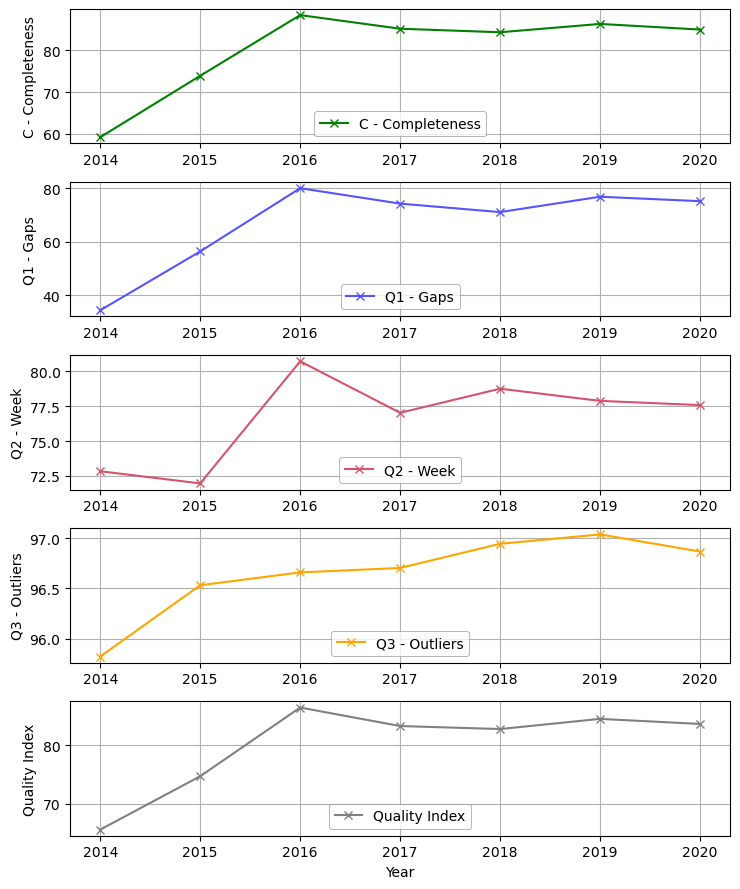

In [283]:
# Calculate the average value of each parameter by year
df_avg_params = df_qc_info.groupby('year').agg({
    'p_availability': 'mean',
    'q1_gaps': 'mean',
    'q2_week': 'mean',
    'q3_outliers': 'mean',
    'quality_index': 'mean'
}).reset_index()

# Create a figure and axis with a custom size
fig, ax = plt.subplots(5, 1, figsize=(7.5, 9), sharex=True)

# Plot each parameter
ax0 = ax[0]
ax0.plot(df_avg_params['year'], df_avg_params['p_availability'], marker='x', color='g', label='C - Completeness')
ax0.set_ylabel('C - Completeness')
ax0.grid(True)
lines, labels = ax0.get_legend_handles_labels()
legend = ax0.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)


ax1 = ax[1]
ax1.plot(df_avg_params['year'], df_avg_params['q1_gaps'], marker='x', color='#5555ff', label='Q1 - Gaps')
ax1.set_ylabel('Q1 - Gaps')
ax1.grid(True)
lines, labels = ax1.get_legend_handles_labels()
legend = ax1.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)


ax2 = ax[2]
ax2.plot(df_avg_params['year'], df_avg_params['q2_week'], marker='x', color='#d3546e', label='Q2 - Week')
ax2.set_ylabel('Q2 - Week')
ax2.grid(True)
lines, labels = ax2.get_legend_handles_labels()
legend = ax2.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)


ax3 = ax[3]
ax3.ylim = (97, None)
ax3.plot(df_avg_params['year'], df_avg_params['q3_outliers'], marker='x', color='Orange', label='Q3 - Outliers')
ax3.set_ylabel('Q3 - Outliers')
ax3.grid(True)
lines, labels = ax3.get_legend_handles_labels()
legend = ax3.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

ax4 = ax[4]
ax4.plot(df_avg_params['year'], df_avg_params['quality_index'], marker='x', color='grey', label='Quality Index')
ax4.set_xlabel('Year')
ax4.set_ylabel('Quality Index')
ax4.grid(True)
lines, labels = ax4.get_legend_handles_labels()

legend = ax4.legend(lines , labels + labels, loc='lower center')
legend.set_frame_on(True)  # Ensure frame is visible
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

# Show xticks on all subplots
for a in ax:
    a.label_outer()  # Hides labels except for the last subplot but keeps ticks visible
    a.tick_params(axis='x', which='both', labelbottom=True)  # Ensure xticks are visible
    
plt.tight_layout()
plt.savefig('./figures/quality_index_avg_year_cemaden.tiff', dpi = 300, bbox_inches='tight')
plt.show()
plt.close()

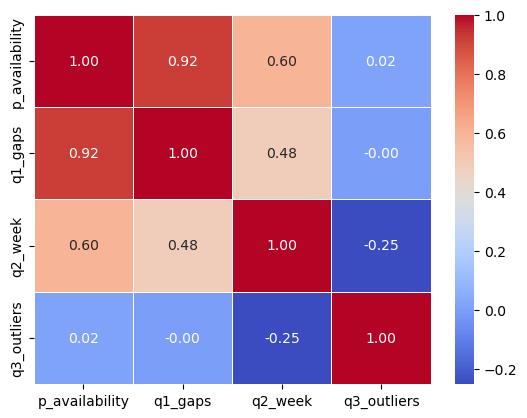

In [284]:
# Select relevant columns for the heatmap
heatmap_data = df_qc_info[['p_availability', 'q1_gaps', 'q2_week', 'q3_outliers']]

# Calculate the correlation matrix
corr = heatmap_data.corr()

# Create a heatmap
# plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Heatmap of df_qc_info Parameters')
plt.show()

In [285]:
df_qc_count = df_qc_info.groupby('quality_label').size().reset_index(name='count')
df_qc_count['percent'] = (df_qc_count['count'] / df_qc_count['count'].sum()) * 100
df_qc_count

,quality_label,count,percent
0,1 - Excellent Quality,12291,53.971809
1,2 - Good Quality,806,3.539279
2,5 - Very Low Quality,9676,42.488912


In [286]:
df_qc_avg = df_qc_info.groupby('quality_label').agg({'p_availability': 'mean'
                                                     , 'q1_gaps':'mean'
                                                     , 'q2_week':'mean'
                                                     , 'q3_outliers':'mean'
                                                     }).reset_index()
df_qc_avg

,quality_label,p_availability,q1_gaps,q2_week,q3_outliers
0,1 - Excellent Quality,99.981892,99.946120,85.671790,96.599253
1,2 - Good Quality,97.692180,93.272569,81.507058,97.089510
2,5 - Very Low Quality,57.485562,28.151683,65.612883,96.833262


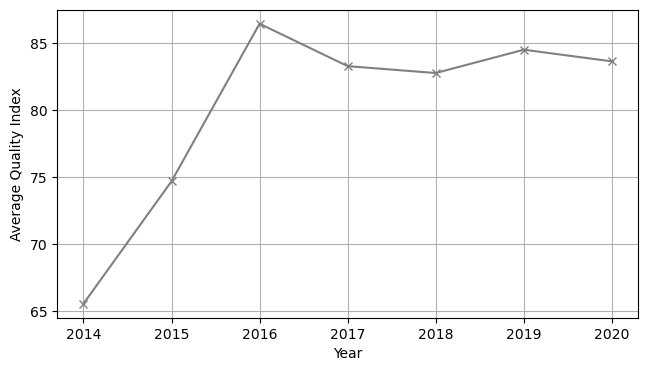

In [287]:
# Calculate the average quality index over the years
df_avg_quality_index = df_qc_info.groupby('year')['quality_index'].mean().reset_index()

# Create a figure and axis with a custom size
fig, ax = plt.subplots(figsize=(7.5, 4))

# Plot the average quality index over the years
ax.plot(df_avg_quality_index['year'], df_avg_quality_index['quality_index'], marker='x', color='grey', label='Average Quality Index')

# Add labels, title, and grid
ax.set_xlabel('Year')
ax.set_ylabel('Average Quality Index')
# ax.set_title('Average Quality Index Over the Years')
ax.grid(True)

plt.savefig('./figures/quality_index_over_the_years_cemaden.png', dpi=1800, bbox_inches='tight')
plt.show()
plt.close()

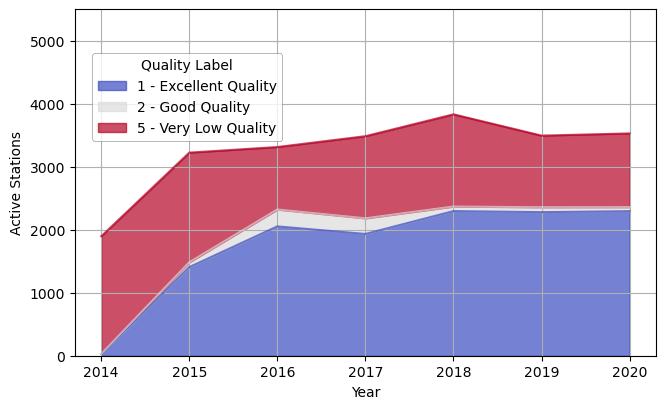

In [288]:

# Group by year and quality label to get the count of active stations
df_active_stations = df_qc_info.groupby(['year', 'quality_label']).size().unstack(fill_value=0)

# Create a stacked area plot with updated figure size
fig, ax = plt.subplots(figsize=(7.5, 4.5))

# Use a colorblind-friendly colormap
df_active_stations.plot(kind='area', stacked=True, ax=ax, colormap='coolwarm', alpha=0.7)

# Add labels, title, and grid
ax.set_xlabel('Year')
ax.set_ylabel('Active Stations')
# ax.set_title('Count of Active Stations by Year and Quality Label')
ax.grid(True)
ax.set_ylim(0, 5500)
# Modify the EXISTING legend from pandas plot
legend = ax.legend()
legend.set_title('Quality Label')  # Set title
legend.set_bbox_to_anchor((0.369, 0.6))  # Set legend position
legend.set_frame_on(True)  # Ensure frame is visible

# Customize frame properties
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

plt.savefig('./figures/active_stations_by_year_and_quality_label_cemaden.tiff', dpi=300, bbox_inches='tight')

plt.show()
plt.close()